In [80]:
import numpy as np   
np.random.seed(42)   ## so that output would be same
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#%matplotlib inline   ## our plot lies on the same notebook
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense
#Evaluation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score



# data processing 

In [81]:
data = pd.read_csv("diabetes.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [82]:
data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]]=data[["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]].replace(0,np.nan)

In [83]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None


In [95]:
l=["Glucose",  "BloodPressure","SkinThickness","Insulin","BMI"]
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].mean().reset_index()
    return temp
for ele in l:
    print(median_target(ele))

   Outcome     Glucose
0        0  110.622000
1        1  142.302239
   Outcome  BloodPressure
0        0      70.844000
1        1      75.272388
   Outcome  SkinThickness
0        0      27.170000
1        1      32.671642
   Outcome     Insulin
0        0  117.172000
1        1  187.615672
   Outcome        BMI
0        0  30.846000
1        1  35.398507


In [96]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 117.172
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 187.615672
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 110.622
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 142.30
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27.170
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32.671642
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70.844
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 75.272388
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.846
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 35.398507


In [97]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB
None


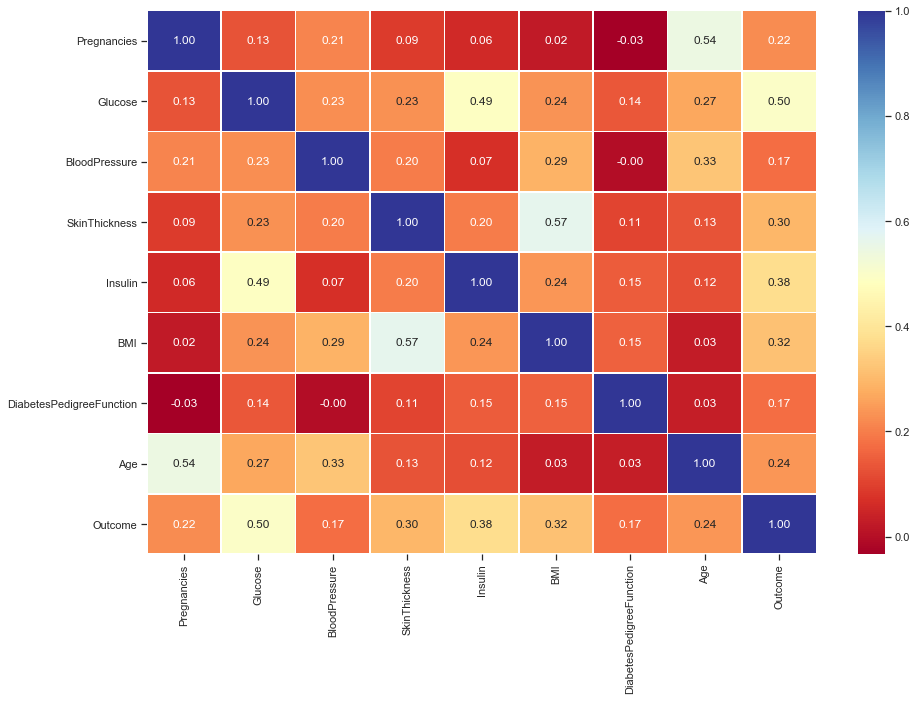

In [98]:
## It shows the correlation(positive,neagative) between different columns(only integer value columns) 
corr_matrix = data.corr()
fig,ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,annot=True,linewidth=0.5,fmt=".2f",cmap="RdYlBu")

# Distribution of data set 

In [99]:

X = data.drop("Outcome",axis=1)
y = data["Outcome"]
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size=0.2)


# Models 

In [100]:

log_reg = LogisticRegression(random_state=0)
log_reg.fit(X_train,y_train);

## Evaluating the model
log_reg = log_reg.score(X_test,y_test)

## Build an model (KNN)
knn = KNeighborsClassifier()
knn.fit(X_train,y_train);
## Evaluating the model
knn = knn.score(X_test,y_test)


## Build an model (Random forest classifier)
clf= RandomForestClassifier()
clf.fit(X_train,y_train);
## Evaluating the model
clf = clf.score(X_test,y_test)
## Build an model (Support Vector Machine)
svm = SVC()
svm.fit(X_train,y_train)
## Evaluating the model
svm = svm.score(X_test,y_test)
print(log_reg,knn,clf,svm)

##Build an model(Neural model )
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200, batch_size=10)
_, nn_acc = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7337662337662337 0.8506493506493507 0.8766233766233766 0.8376623376623377
Epoch 1/200
62/62 [==============================] - 0s 2ms/step - loss: 2.4748 - accuracy: 0.4414
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.9582 - accuracy: 0.5717
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6546 - accuracy: 0.6938
Epoch 4/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.7052
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6204 - accuracy: 0.7117
Epoch 6/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6124 - accuracy: 0.7085
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.7150
Epoch 8/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.7166
Epoch 9/200
62/62 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.7134
Epoch 10/200
62/62 [=============

62/62 [==============================] - 0s 2ms/step - loss: 0.3574 - accuracy: 0.8632
Epoch 82/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.8583
Epoch 83/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3729 - accuracy: 0.8502
Epoch 84/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8502
Epoch 85/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3576 - accuracy: 0.8583
Epoch 86/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8355
Epoch 87/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3696 - accuracy: 0.8599
Epoch 88/200
62/62 [==============================] - 0s 1ms/step - loss: 0.3793 - accuracy: 0.8518
Epoch 89/200
62/62 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.8599
Epoch 90/200
62/62 [==============================] - 0s 1ms/step - loss: 0.3582 - accuracy: 0.8599
Epoch 91/200


62/62 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.8648
Epoch 163/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3421 - accuracy: 0.8697
Epoch 164/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3376 - accuracy: 0.8681
Epoch 165/200
62/62 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.86 - 0s 2ms/step - loss: 0.3454 - accuracy: 0.8648
Epoch 166/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8697
Epoch 167/200
62/62 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.8648
Epoch 168/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.8795
Epoch 169/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3299 - accuracy: 0.8697
Epoch 170/200
62/62 [==============================] - 0s 2ms/step - loss: 0.3460 - accuracy: 0.8648
Epoch 171/200
62/62 [==============================] - 0s 2ms/s

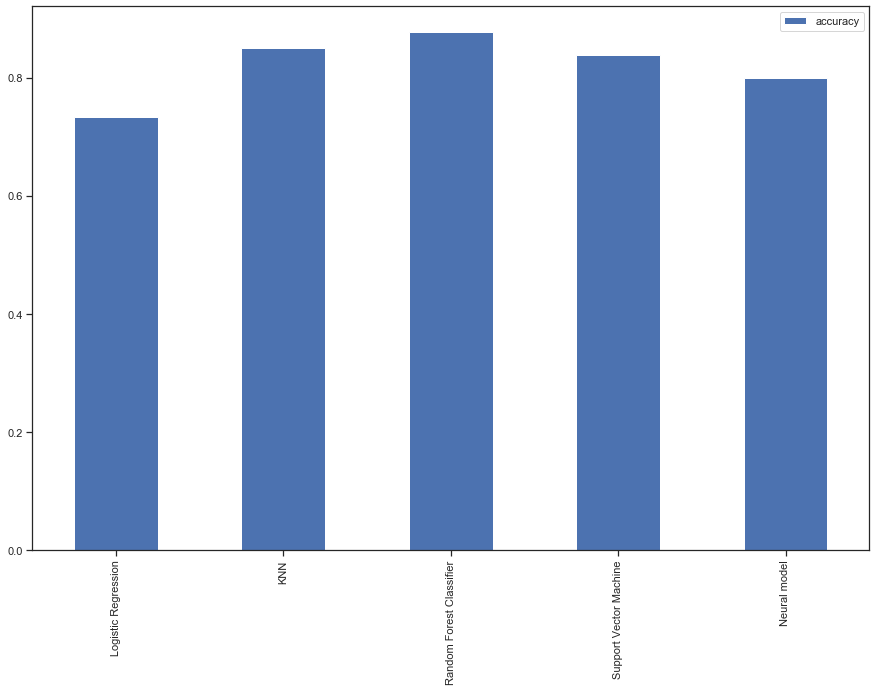

In [102]:
model_compare = pd.DataFrame({"Logistic Regression":log_reg,
"KNN":knn,
"Random Forest Classifier":clf,
"Support Vector Machine":svm,"Neural model":nn_acc},
index=["accuracy"])
model_compare.T.plot.bar(figsize=(15,10));